Merge ORES and Revert Scores
===

 - Load (calibrated) ORES scores
 - Load revert probability scores
 - Join them

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [4]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [5]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Load (calibrated) ORES scores

In [6]:
s = datetime.now()
audit_dir = os.path.join(derived_data_dir, 'audit')
calibrated_probs_filepath = os.path.join(audit_dir, 'sample3_ores_scores_calibrated.csv')
ores_df = pd.read_csv(calibrated_probs_filepath)
print(f"{datetime.now() - s}")
len(ores_df)

0:00:16.525587


34289314

In [7]:
ores_df.head()

,rev_id,damaging_prob,damaging_prob_calibrated
0,846835190,0.014069,0.017446
1,923997118,0.597491,0.879206
2,867368228,0.304521,0.266850
3,888337768,0.010122,0.016759
4,917010365,0.013616,0.017366


### Load revert scores

In [9]:
# read the revert scores
s = datetime.now()
audit_dir = os.path.join(derived_data_dir, 'audit')
predictions_dir = os.path.join(audit_dir, 'predictions')
revert_score_filepath = os.path.join(predictions_dir, 'prediction_2020-08-01.pkl')
revert_score_df = pd.read_pickle(revert_score_filepath)
print(f"{datetime.now() - s}")
len(revert_score_df)

0:00:00.144639


11738345

In [11]:
rev_id_list = []
with open('/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample3-features/rev_id_2020-08-01T05:40:00Z.txt') as infile:
    for line in infile:
        if line.strip() != '':
            rev_id = int(line)
            rev_id_list.append(rev_id)
assert len(rev_id_list) == len(revert_score_df)

In [12]:
revert_score_df['rev_id'] = rev_id_list

In [16]:
revert_score_df = revert_score_df.rename(columns={'test_label': 'is_reverted_1week', 'test_calib': 'revert_prob'})

In [24]:
# be explicit, and set the 'is_reverted' column to be one of the specific instantiations of the outcome
revert_score_df['is_reverted'] = revert_score_df.is_reverted_1week

In [51]:
revert_score_df.head()

,revert_prob,is_reverted_1week,rev_id,is_reverted
0,0.033107,False,857219031,False
1,0.293368,False,857219035,False
2,0.552572,True,857219034,True
3,0.008702,False,857219036,False
4,0.004850,False,857219037,False


### Load revert metadata

### Merge and save scores

In [56]:
s = datetime.now()
df = pd.merge(ores_df, revert_score_df, on='rev_id', how='inner')
print(f"{datetime.now() - s}")
len(df)

0:00:22.615668


11735531

In [57]:
df.head()

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted_1week,is_reverted
0,867368228,0.304521,0.266850,0.125768,False,False
1,867140549,0.121477,0.051329,0.085052,False,False
2,862458099,0.008124,0.016422,0.069691,True,True
3,866634222,0.030305,0.020573,0.021695,False,False
4,862308858,0.184570,0.094484,0.243350,True,True


#### Save and load scores

In [58]:
audit_dir = os.path.join(derived_data_dir, 'audit')
merged_preds_df_filepath = os.path.join(audit_dir, 'merged_preds.pkl')
df.to_pickle(merged_preds_df_filepath)
print("Finished.")

Finished.


In [59]:
# load the merged predictions dataframe
s = datetime.now()
audit_dir = os.path.join(derived_data_dir, 'audit')
merged_preds_df_filepath = os.path.join(audit_dir, 'merged_preds.pkl')
merged_preds_df = pd.read_pickle(merged_preds_df_filepath)
print(f"{datetime.now() - s}")
len(merged_preds_df)

0:00:00.867604


11735531

In [60]:
df = merged_preds_df
df.head(2)

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted_1week,is_reverted
0,867368228,0.304521,0.266850,0.125768,False,False
1,867140549,0.121477,0.051329,0.085052,False,False


### Visualize and group

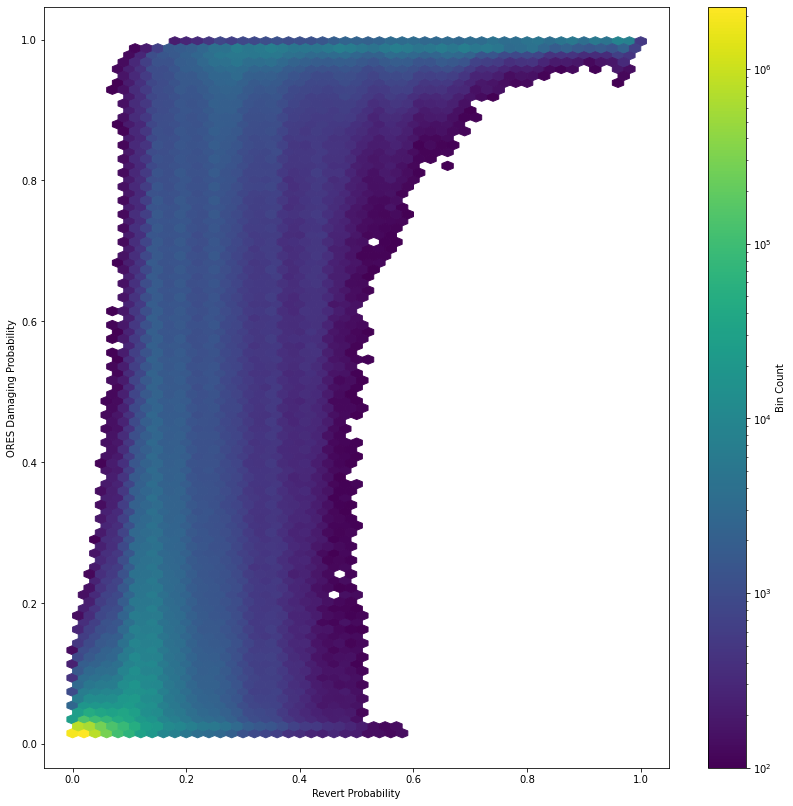

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
hb = plt.hexbin(df.revert_prob, df.damaging_prob_calibrated, bins='log', gridsize=(50,50), mincnt=100)
plt.xlabel('Revert Probability')
plt.ylabel('ORES Damaging Probability')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Bin Count')

plt.show()

In [65]:
df['revert_group'] = df.revert_prob.map(lambda rp: int(rp * 100))

In [66]:
Counter(df.revert_group).most_common(20)

[(0, 2368565),
 (1, 1872492),
 (2, 1450783),
 (3, 761606),
 (4, 653471),
 (5, 346844),
 (6, 328908),
 (11, 242364),
 (9, 230201),
 (14, 222024),
 (13, 211230),
 (8, 198217),
 (7, 170846),
 (10, 170638),
 (15, 155796),
 (12, 140032),
 (18, 123921),
 (16, 120046),
 (17, 118095),
 (19, 113439)]

In [67]:
xs = []
ys =[]
for group_num, subset in df.groupby('revert_group'):
    pct_reverted = np.sum(subset.is_reverted) / len(subset)
    pct_predicted = (group_num / 100) + 0.005
    xs.append(pct_predicted)
    ys.append(pct_reverted)

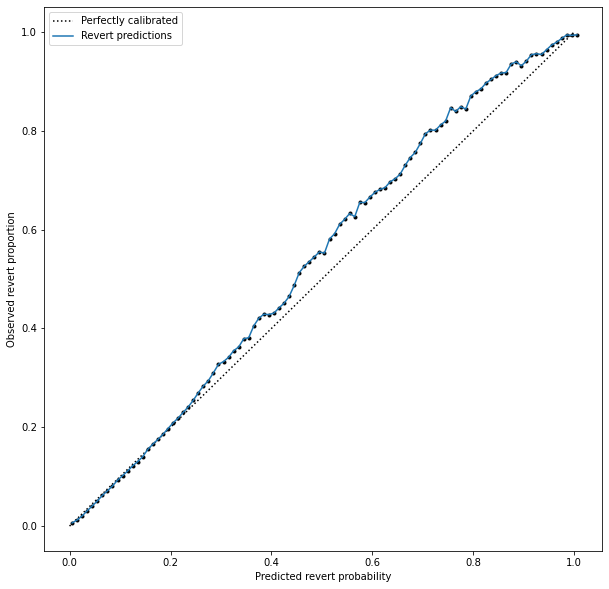

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(xs, ys, label='Revert predictions')
plt.scatter(xs, ys, color='black', marker='.')
plt.legend()
plt.xlabel("Predicted revert probability")
plt.ylabel("Observed revert proportion")
plt.show()

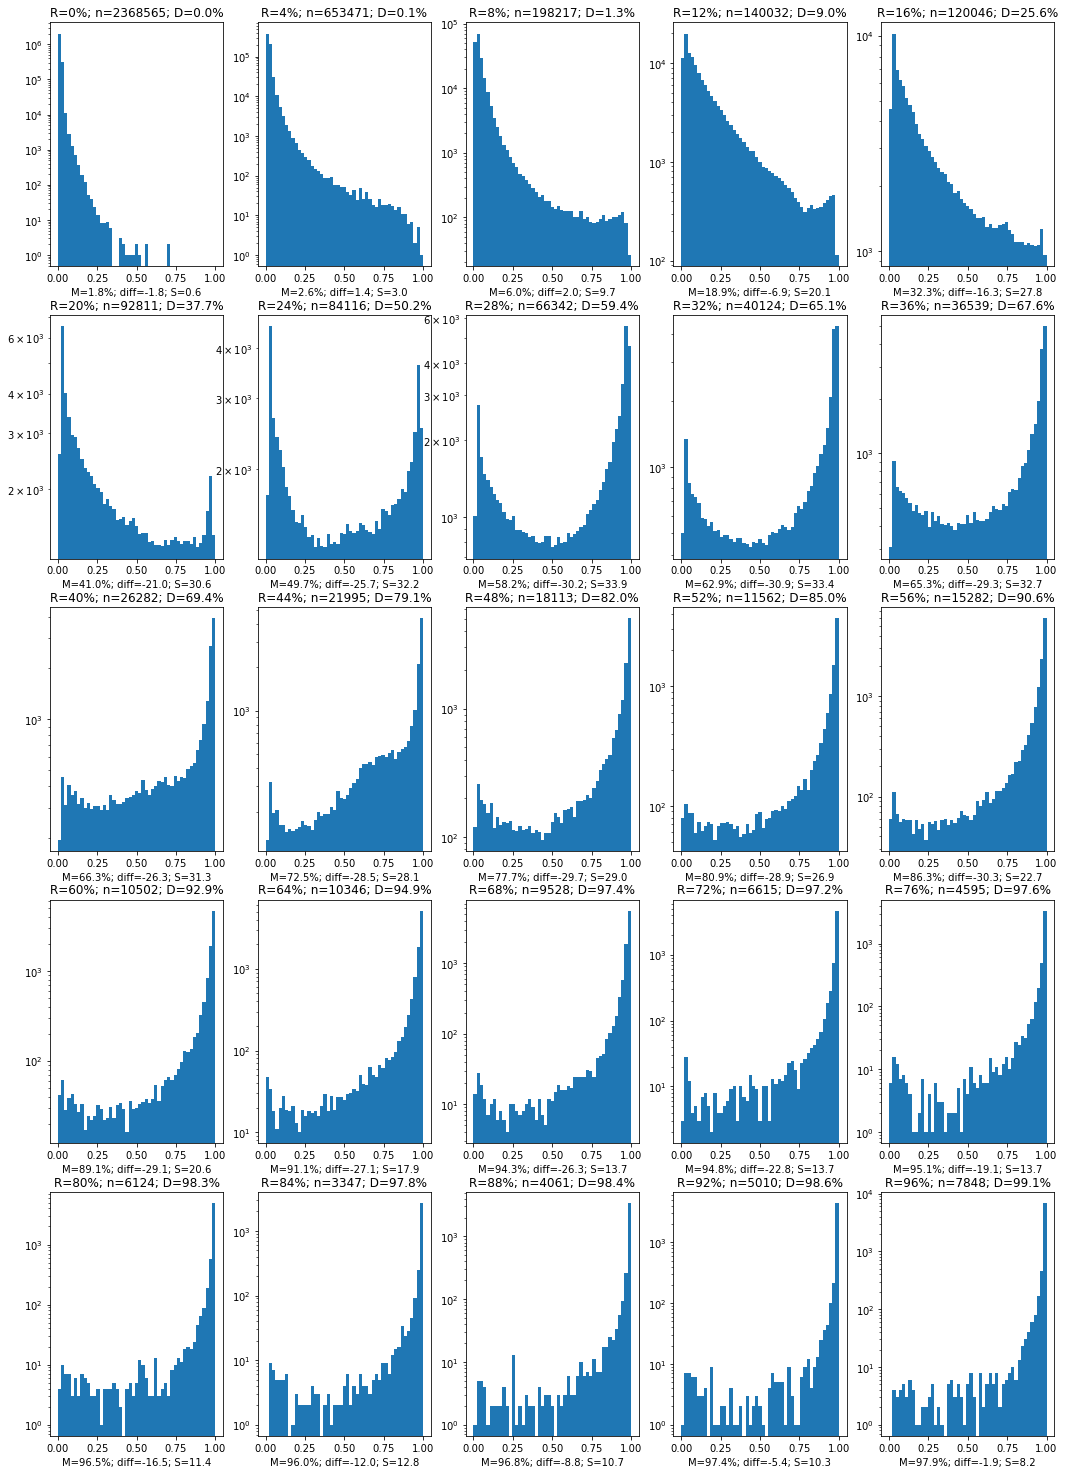

In [69]:
fig, axes = plt.subplots(5, 5, figsize=(18, 26))

bins = np.linspace(0, 1, num=50)

group = 0
for row in axes:
    for ax in row:
        subset = df[df.revert_group == group]
        ax.set_title(f"R={group}%; n={len(subset)}; D={np.sum(subset.damaging_prob_calibrated >= 0.5) / len(subset)*100:.1f}%")
        
        ax.hist(subset.damaging_prob_calibrated, bins=bins, log=True)
        
        mean_damaging_prob = np.mean(subset.damaging_prob_calibrated)
        mean_diff = (group / 100) - mean_damaging_prob
        std_damaging_prob = np.std(subset.damaging_prob_calibrated)
        ax.set_xlabel(f'M={mean_damaging_prob*100:.1f}%; diff={mean_diff*100:.1f}; S={std_damaging_prob*100:.1f}')
        
        group += 4  # count by 4s up to 100

plt.show()

In [36]:
import scipy.stats
d = []
for group_num, subset in df.groupby('revert_group'):
    mean_damaging_prob = np.mean(subset.damaging_prob_calibrated)
    mean_diff = (group_num / 100) - mean_damaging_prob
    std_damaging_prob = np.std(subset.damaging_prob_calibrated)
    #scipy.stats.pearsonr(subset., y)
    damaging_subset = subset[subset.damaging_prob_calibrated >= 0.9]
    nondamaging_subset = subset[subset.damaging_prob_calibrated <= 0.1]
    d.append({
        'group': group_num,
        'n': len(subset),
        'mean_damaging_prob': mean_damaging_prob,
        'std_damaging_prob': std_damaging_prob,
        'mean_diff': mean_diff,
        'abs_mean_diff': np.abs(mean_diff),
        'rev_sample': ' '.join([str(r) for r in subset.sample(n=5).rev_id]),
        'damaging_rev_sample': ' '.join([str(r) for r in damaging_subset.sample(n=min(len(damaging_subset), 5)).rev_id]) if len(damaging_subset) > 0 else '',
        'nondamaging_rev_sample': ' '.join([str(r) for r in nondamaging_subset.sample(n=min(len(nondamaging_subset), 5)).rev_id]) if len(nondamaging_subset) > 0 else ''
    })
len(d)

101

In [37]:
group_df = pd.DataFrame(d)
len(group_df)

101

In [38]:
group_df.head()

,group,n,mean_damaging_prob,std_damaging_prob,mean_diff,abs_mean_diff,rev_sample,damaging_rev_sample,nondamaging_rev_sample
0,0,2368565,0.018445,0.005618,-0.018445,0.018445,875102113 863118310 872232405 861842911 859895177,,875377360 876054161 864133831 860503770 873969330
1,1,1872492,0.020238,0.009641,-0.010238,0.010238,874021325 857929051 858458905 875758750 860755881,868289623,872414913 861295765 859629496 859685457 861387860
2,2,1450783,0.021874,0.013368,-0.001874,0.001874,861957976 869972292 863715212 864138117 858102500,860080052 866943604 872307441 864533301 862306463,866909024 863307913 866225646 858281680 861120208
3,3,761606,0.023642,0.018528,0.006358,0.006358,871380187 872963625 875511253 860168900 874041683,865874219 867888694 865301813 871895445 860269703,862921676 875049912 872626084 863649859 859986463
4,4,653471,0.026244,0.030399,0.013756,0.013756,863853742 863110523 875653973 873208078 865099622,862979108 858367226 874789270 869289537 864575866,874466379 858353353 865291286 866629222 862517598


In [39]:
group_df.sort_values(by='abs_mean_diff', ascending=False)

,group,n,mean_damaging_prob,std_damaging_prob,mean_diff,abs_mean_diff,rev_sample,damaging_rev_sample,nondamaging_rev_sample
32,32,40124,0.629284,0.334172,-0.309284,0.309284,871152101 864292446 858388979 864075834 874354396,865788547 869002663 863721955 875981911 868308451,861862617 873968586 872303794 869728555 870879255
55,55,13769,0.858165,0.230582,-0.308165,0.308165,860289536 874058321 871983971 868532006 858667713,865270143 861057964 863765344 875873547 858558198,862406918 870867601 864304263 858651853 873274782
46,46,18689,0.767028,0.289637,-0.307028,0.307028,875449543 866367131 859974207 873643303 861241838,867515161 867696446 866458242 859866179 873640044,872196139 859559999 858846210 865214681 862455452
34,34,41435,0.646936,0.328366,-0.306936,0.306936,865055118 857924020 870058773 874731089 875670741,871932581 861280625 867218513 870506742 860967902,875700247 858231422 864314084 863959850 868681993
31,31,42190,0.613257,0.333681,-0.303257,0.303257,875069538 859306447 862496511 867938518 870852369,871502893 868333910 862878616 869418376 864373498,861294288 868929283 875574218 866740449 861129868
...,...,...,...,...,...,...,...,...,...
97,97,6499,0.977265,0.088422,-0.007265,0.007265,857347436 865271910 868511766 873529784 874368735,868136258 866869830 862757482 861131081 866297702,868043849 866903639 869131579 876077729 872291092
3,3,761606,0.023642,0.018528,0.006358,0.006358,871380187 872963625 875511253 860168900 874041683,865874219 867888694 865301813 871895445 860269703,862921676 875049912 872626084 863649859 859986463
9,9,230201,0.084738,0.124119,0.005262,0.005262,873503047 858179630 870499911 857407592 875402371,869029417 862302124 862035794 874711887 860568081,869176221 874011001 868534959 865500669 874525494
2,2,1450783,0.021874,0.013368,-0.001874,0.001874,861957976 869972292 863715212 864138117 858102500,860080052 866943604 872307441 864533301 862306463,866909024 863307913 866225646 858281680 861120208


In [40]:
group_df.sort_values(by='std_damaging_prob', ascending=False)

,group,n,mean_damaging_prob,std_damaging_prob,mean_diff,abs_mean_diff,rev_sample,damaging_rev_sample,nondamaging_rev_sample
28,28,66342,0.582338,0.338900,-0.302338,0.302338,862836174 863366936 858675602 866757358 870637649,868290910 869475085 863380968 875790025 871065144,869835543 871389822 858809038 863872506 868745750
29,29,59541,0.587600,0.338406,-0.297600,0.297600,868971944 860964126 864105153 859408109 868435424,867404752 870625309 871989382 874824373 872967244,861612897 862962390 868641965 870199625 860724840
26,26,74218,0.522212,0.335228,-0.262212,0.262212,863648234 864934262 864513498 867996158 867008428,859790863 874694853 860510490 875287539 872572678,862024209 874540704 864642550 874465256 866110085
27,27,69509,0.541200,0.334987,-0.271200,0.271200,874685727 864213901 865848496 867273142 869351538,872032560 859952988 867536835 867888682 870010971,865247458 874362393 861174327 863097286 862599401
30,30,45926,0.594044,0.334495,-0.294044,0.294044,870272957 857527163 863086626 858544334 857753671,860969620 867736859 874622869 861435108 870054359,874995702 872410091 861984796 870177055 862486298
...,...,...,...,...,...,...,...,...,...
4,4,653471,0.026244,0.030399,0.013756,0.013756,863853742 863110523 875653973 873208078 865099622,862979108 858367226 874789270 869289537 864575866,874466379 858353353 865291286 866629222 862517598
3,3,761606,0.023642,0.018528,0.006358,0.006358,871380187 872963625 875511253 860168900 874041683,865874219 867888694 865301813 871895445 860269703,862921676 875049912 872626084 863649859 859986463
2,2,1450783,0.021874,0.013368,-0.001874,0.001874,861957976 869972292 863715212 864138117 858102500,860080052 866943604 872307441 864533301 862306463,866909024 863307913 866225646 858281680 861120208
1,1,1872492,0.020238,0.009641,-0.010238,0.010238,874021325 857929051 858458905 875758750 860755881,868289623,872414913 861295765 859629496 859685457 861387860


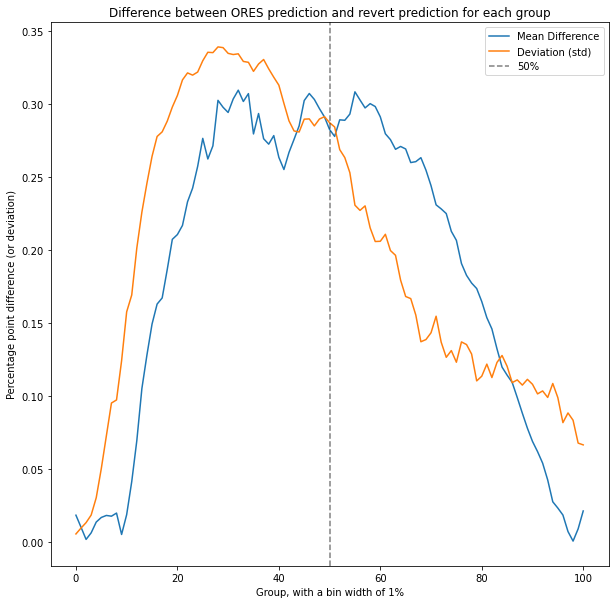

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(group_df.group, group_df.abs_mean_diff, label='Mean Difference')
ax.plot(group_df.group, group_df.std_damaging_prob, label='Deviation (std)')
ax.axvline(50, color='k', alpha=0.5, linestyle='--', label='50%')
plt.legend()
plt.title('Difference between ORES prediction and revert prediction for each group')
plt.xlabel('Group, with a bin width of 1%')
plt.ylabel('Percentage point difference (or deviation)')
plt.show()

In [84]:
# https://en.wikipedia.org/w/index.php?diff=

In [50]:
group_num = 34
print("damaging")
for link in [f"https://en.wikipedia.org/w/index.php?diff={rev_id}" for rev_id in group_df[group_df.group == group_num].damaging_rev_sample.iloc[0].split(" ")]:
    print(link)
print("nondamaging")    
for link in [f"https://en.wikipedia.org/w/index.php?diff={rev_id}" for rev_id in group_df[group_df.group == group_num].nondamaging_rev_sample.iloc[0].split(" ")]:
    print(link)

damaging
https://en.wikipedia.org/w/index.php?diff=871932581
https://en.wikipedia.org/w/index.php?diff=861280625
https://en.wikipedia.org/w/index.php?diff=867218513
https://en.wikipedia.org/w/index.php?diff=870506742
https://en.wikipedia.org/w/index.php?diff=860967902
nondamaging
https://en.wikipedia.org/w/index.php?diff=875700247
https://en.wikipedia.org/w/index.php?diff=858231422
https://en.wikipedia.org/w/index.php?diff=864314084
https://en.wikipedia.org/w/index.php?diff=863959850
https://en.wikipedia.org/w/index.php?diff=868681993
